# Import Libraries
---

In [10]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pylab

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#Buat subplot
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from pandas import Timestamp

# II. Data Loading
---

In [11]:
# Read data
df = pd.read_csv('./data_for_modelling.csv')

# Show 5 data
df.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [12]:
# Show info from data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77692 entries, 0 to 77691
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                77692 non-null  object 
 1   status              77692 non-null  object 
 2   fulfilment          77692 non-null  object 
 3   sales_channel       77692 non-null  object 
 4   ship_service_level  77692 non-null  object 
 5   category            77692 non-null  object 
 6   size                77692 non-null  object 
 7   amazon_standard_id  77692 non-null  object 
 8   qty                 77692 non-null  int64  
 9   currency            77692 non-null  object 
 10  sales               77692 non-null  float64
 11  clean_ship_state    77692 non-null  object 
 12  promotion_used      77692 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 7.2+ MB


In [13]:
# Change data type feature date to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by feature sales and quantity
df1 = df.groupby('date').agg(
    sales_sum=('sales', 'sum'), # sales is aggregated by summing
    qty_sum=('qty', 'sum') # qty is aggregated by averaging
).reset_index().sort_values('date')

# Set feature date as index
df1 = df1.set_index('date')

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2022-03-31 to 2022-06-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sales_sum  91 non-null     float64
 1   qty_sum    91 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 2.1 KB


In [15]:
# Mengetahui frekuensi dari Day index
freq = pd.infer_freq(df1.index)
print(freq)

D


# III. Data Overview
---

In [16]:
# Plot data menggunakan plotly
fig = px.line(df1, x=df1.index, y="sales_sum", title='Sales Overtime')
fig.show()

Based on our personal judgment, the number of sales at the beginning and end dates of the dataset does not accurately represent the overall data for those days, which may introduce bias. Therefore, the data on those dates will be dropped.

In [17]:
# Drop rows by first and last index
df1 = df1.drop([df1.index[0], df1.index[-1]])

# describe data
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
sales_sum,89.0,574595.825843,116275.763966,361256.0,482452.0,597695.0,651189.0,856411.0
qty_sum,89.0,872.831461,193.739295,531.0,724.0,868.0,1003.0,1374.0


## Decomposing
---

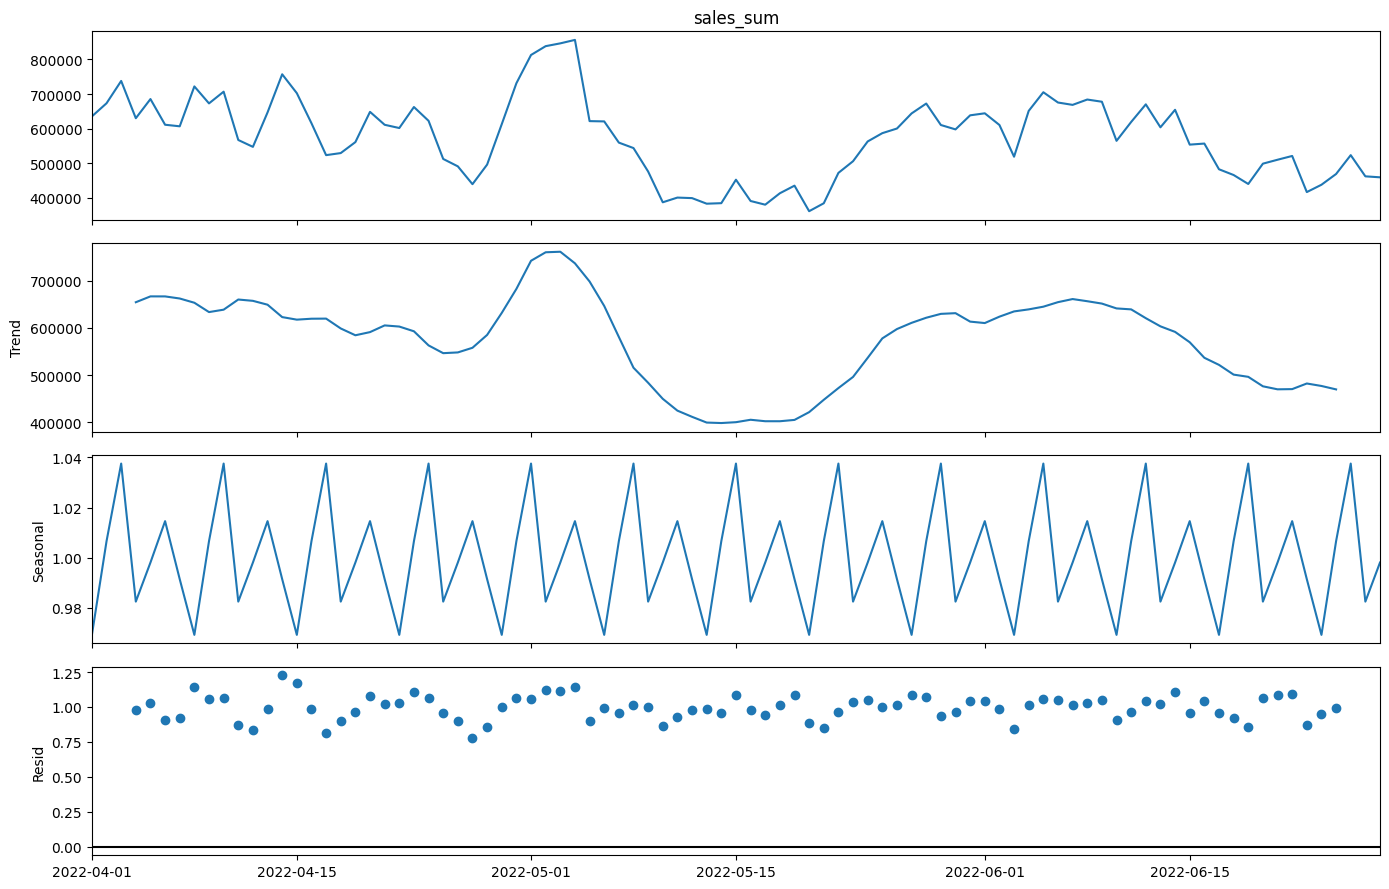

In [18]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df1['sales_sum'], model='multiplicative', period=7) # interval data: harian, maka periode 365.
ax=res.plot()
plt.show()

## Splitting Data
---

In [19]:
# Check length 
len(df1)

89

In [20]:
# Menggunakan train:test -> 90%
train_len = int(len(df1) * 0.90)
train_len

80

In [21]:
# Splitting train dan test
train = df1[:train_len]
test = df1[train_len:]

In [22]:
# Create the figure
fig = go.Figure()

# Add traces for each DataFrame
fig.add_trace(go.Scatter(y=train['sales_sum'], x=train.index, mode='lines', name='Train'))
fig.add_trace(go.Scatter(y=test['sales_sum'], x=test.index, mode='lines', name='Test'))

# Update layout (optional)
fig.update_layout(title='Total Sales',
                  xaxis_title='Date',
                  yaxis_title='Sales')

# Show the figure
fig.show()

## Check Stationarity
---

In [23]:
# Create a function to check stationarity

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [24]:
# Check stationarity
check_stationarity(df1['sales_sum'])

ADF Statistic: -2.904593
p-value: 0.044817
Critical Values:
	1%: -3.508
	5%: -2.895
	10%: -2.585
Stationary


## ACF & PACF
---

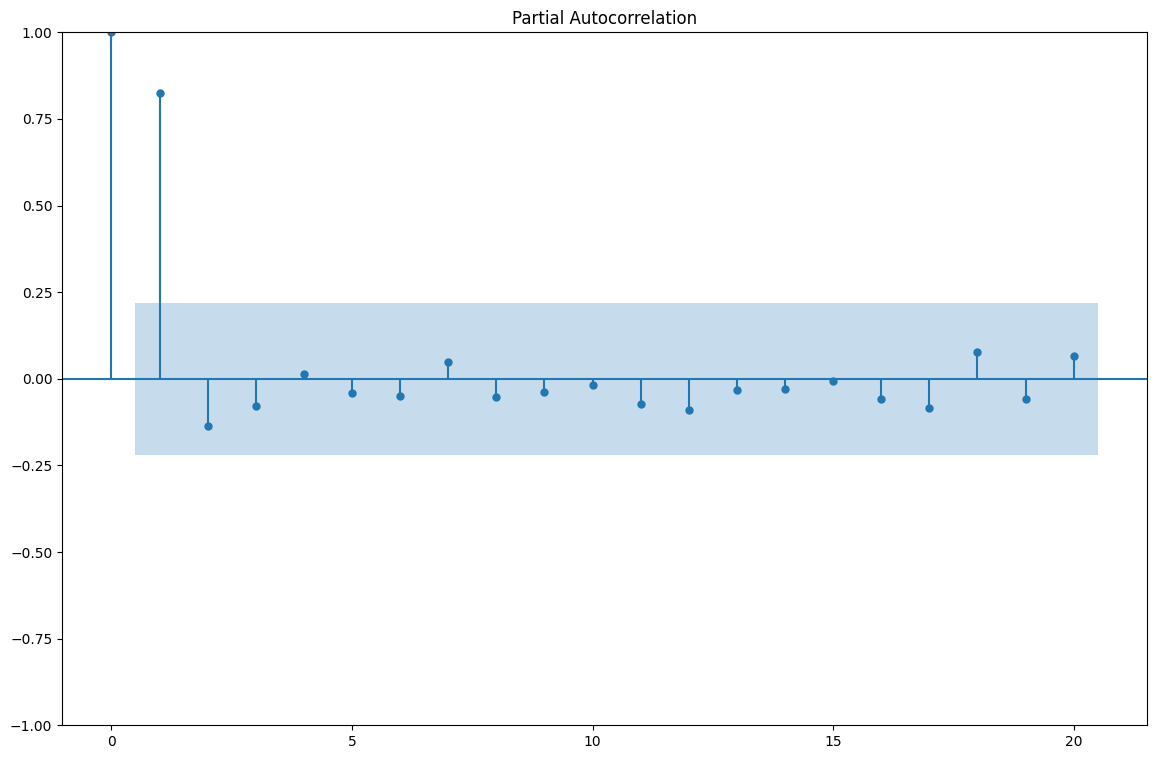

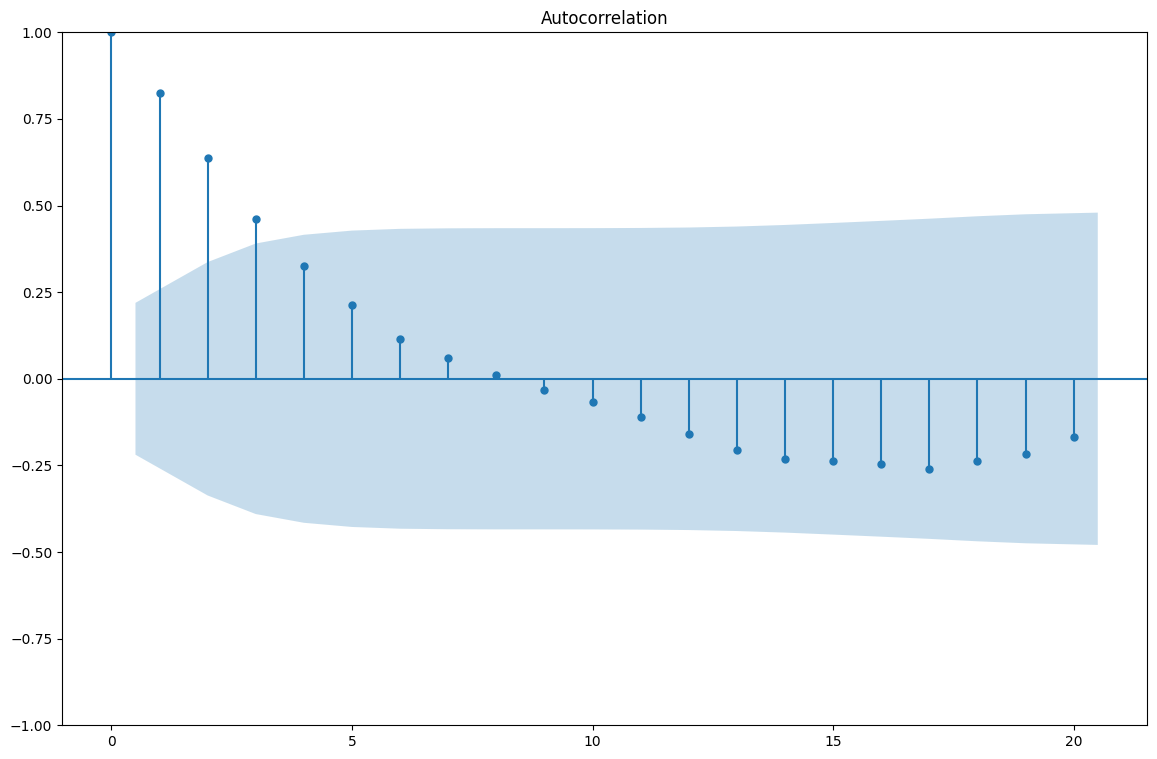

In [25]:
# Plot ACF & PACF

plot_pacf(train['sales_sum'])
plot_acf(train['sales_sum'])
plt.show()

## AIC
---

In [26]:
# function to get aic score, p, d, and q

def calculate_aic(data, num_p, num_d, num_q):
  # create empty df to store p, d, q, and aic score
  df1 = pd.DataFrame()

  # create empty list to store p, d, q
  pdq = [[], [], []]

  # create empty list to store aic score
  aic_score = []

  # looping to get p, d, q
  for lag_p in range(num_p + 1):
    for lag_d in range(num_d + 1):
      for lag_q in range(num_q + 1):
        # model definition
        model = ARIMA(data, order=(lag_p, lag_d, lag_q))
        # model training
        result = model.fit()
        # filling empty list with aic score which generated from model training
        aic_score.append(result.aic)
        # filling empty list with lag_p, lag_d, and lag_q
        pdq[0].append(lag_p)
        pdq[1].append(lag_d)
        pdq[2].append(lag_q)

  # value placement to dataframe
  df1['AIC'] = aic_score
  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]

  df1.sort_values('AIC', inplace=True)
  return df1

In [27]:
# Find best model of ARIMA with combinations of p=1, d=0, q=2
calculate_aic(train['sales_sum'], 1, 0, 2)

,AIC,p,d,q
3,2005.313030,1,0,0
4,2006.005602,1,0,1
5,2007.469855,1,0,2
2,2027.074447,0,0,2
1,2049.408493,0,0,1
0,2368.952759,0,0,0


# 4. Model Definition and Training
---

## ARIMA
---

### Model Definition
---

In [28]:
# Train ARIMAwith the best configuration
model_arima = ARIMA(train['sales_sum'], order=(1, 0, 2))

# model training
result_arima = model_arima.fit()

# Print result AIC Score
print("AIC Score: ", result_arima.aic)

AIC Score:  2007.4698545748938


### Model Prediction
---

In [29]:
# Train prediction
pred_train_ar = result_arima.predict(start=train['sales_sum'].index[0], end=train['sales_sum'].index[-1])
pred_train_ar = pred_train_ar.rename('predict')

# Concate with actual train-set
act_vs_pred_train_arima = pd.concat([train['sales_sum'], pred_train_ar], axis=1)
act_vs_pred_train_arima

,sales_sum,predict
2022-04-01,635277.0,585524.618749
2022-04-02,673257.0,626976.040141
2022-04-03,737777.0,661759.385243
2022-04-04,630021.0,718420.873378
2022-04-05,685402.0,609726.320419
...,...,...
2022-06-15,553686.0,641881.691067
2022-06-16,556744.0,551338.450744
2022-06-17,482452.0,555638.813438
2022-06-18,465831.0,495148.391428


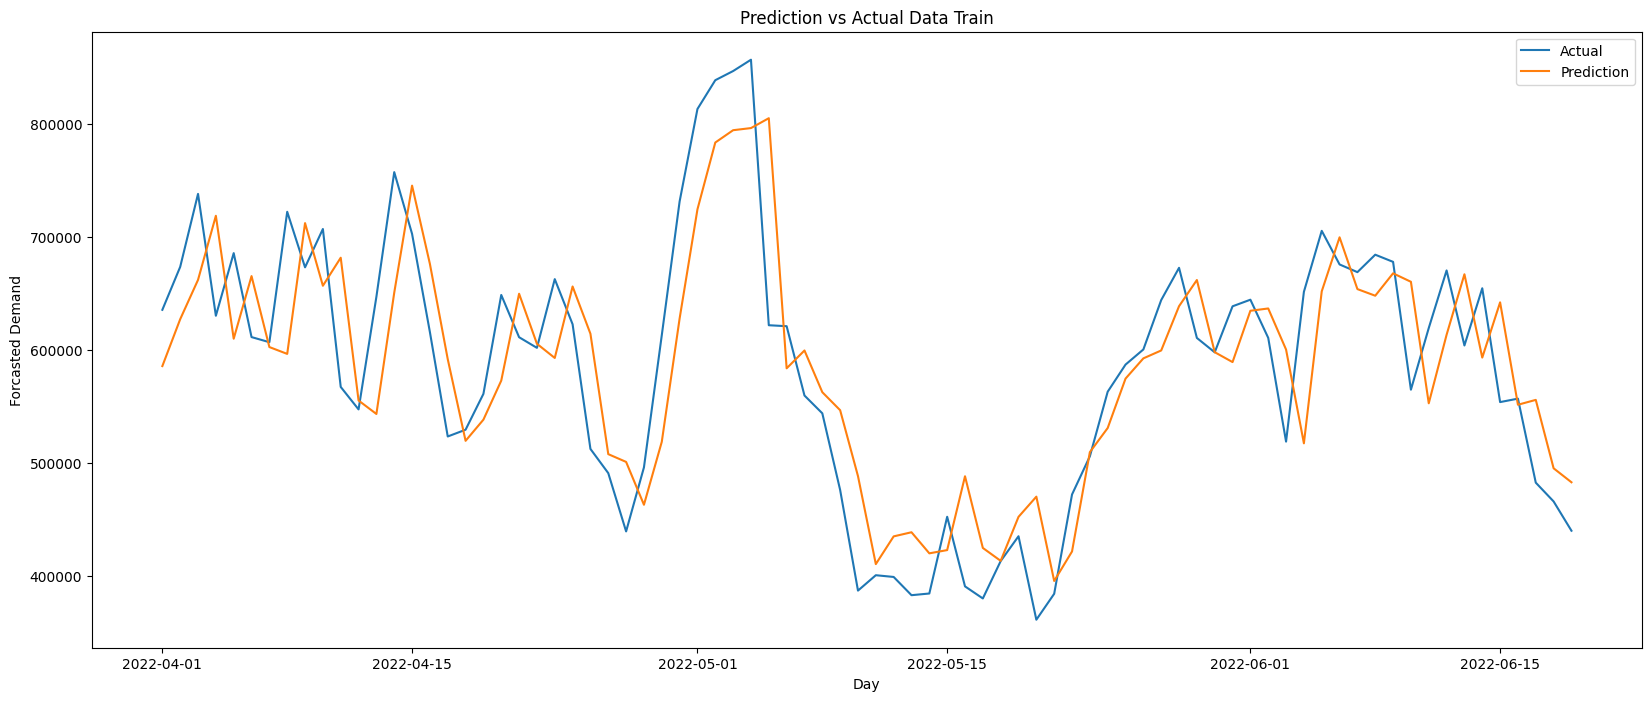

In [30]:
# plot predict train
plt.figure(figsize=(20,8))
plt.plot(train['sales_sum'], label='Actual')
plt.plot(pred_train_ar, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Train')
plt.legend()
plt.show()

In [ ]:
# Test prediction
pred_test_ar = result_arima.predict(start=test['sales_sum'].index[0], end=test['sales_sum'].index[-1])
pred_test_ar = pred_test_ar.rename('predict')

# Concate with actual test-set
act_vs_pred_test_arima = pd.concat([test['sales_sum'], pred_test_ar], axis=1)
act_vs_pred_test_arima

,sales_sum,predict
2022-06-20,498641.0,465605.499051
2022-06-21,509995.0,491555.411967
2022-06-22,520920.0,515500.346302
2022-06-23,416522.0,533343.708644
2022-06-24,437710.0,546640.282158
2022-06-25,468786.0,556548.665109
2022-06-26,523264.0,563932.225436
2022-06-27,462018.0,569434.330410
2022-06-28,459203.0,573534.406498


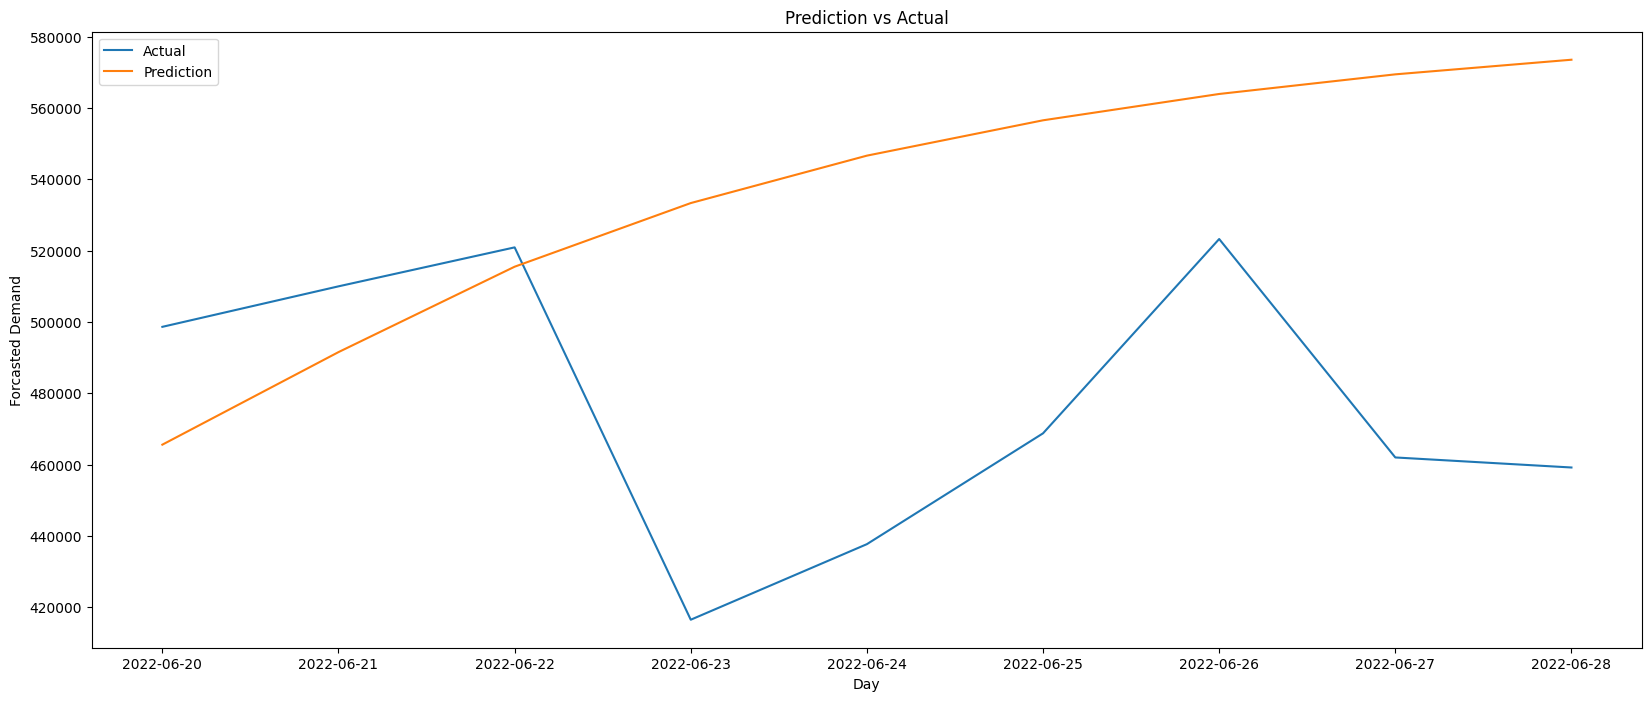

In [32]:
# plot predict test
plt.figure(figsize=(20,8))
plt.plot(test['sales_sum'], label='Actual')
plt.plot(pred_test_ar, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

### Evaluation
---

In [33]:
# Evaluation Train MAE
mae_train_ar = mean_absolute_error(train['sales_sum'], pred_train_ar)

# Evaluation Test MAE
mae_test_ar = mean_absolute_error(test['sales_sum'], pred_test_ar)

# Print result evaluation
print(f"MAE Train : {mae_train_ar}")
print(f"MAE Test : {mae_test_ar}")

MAE Train : 52350.005853383474
MAE Test : 70313.92899280952


In [34]:
# Evaluation train
mape_train_ar = mean_absolute_percentage_error(train['sales_sum'], pred_train_ar)

# Evaluation test
mape_test_ar = mean_absolute_percentage_error(test['sales_sum'], pred_test_ar)

# Print result evaluation
print(f"MAPE Train : {mape_train_ar}")
print(f"MAPE Test : {mape_test_ar}")

MAPE Train : 0.09155765811019305
MAPE Test : 0.1542832971035325


## SARIMAX
---

### Model Definition
---

In [50]:
# Train SARIMAX dengan kombinasi terbaik
model_sarimax = SARIMAX(train['sales_sum'], order=(1,0,1), seasonal_order=(1,0,1, 7))

# Model Training
result_sarimax = model_sarimax.fit()

print("AIC Score: ", result_sarimax.aic)

AIC Score:  2018.0936999900905


In [51]:
# Train prediction
pred_train_sarimax = result_sarimax.predict(start=train['sales_sum'].index[0], end=train['sales_sum'].index[-1])
pred_train_sarimax = pred_train_sarimax.rename('predict')

# Concate with actual train-set
act_vs_pred_train_sarimax = pd.concat([train['sales_sum'], pred_train_sarimax], axis=1)
act_vs_pred_train_sarimax

,sales_sum,predict
2022-04-01,635277.0,0.000000
2022-04-02,673257.0,630094.059110
2022-04-03,737777.0,669596.350504
2022-04-04,630021.0,734581.800492
2022-04-05,685402.0,617127.197590
...,...,...
2022-06-15,553686.0,659301.168522
2022-06-16,556744.0,539121.711664
2022-06-17,482452.0,551784.043749
2022-06-18,465831.0,485197.463137


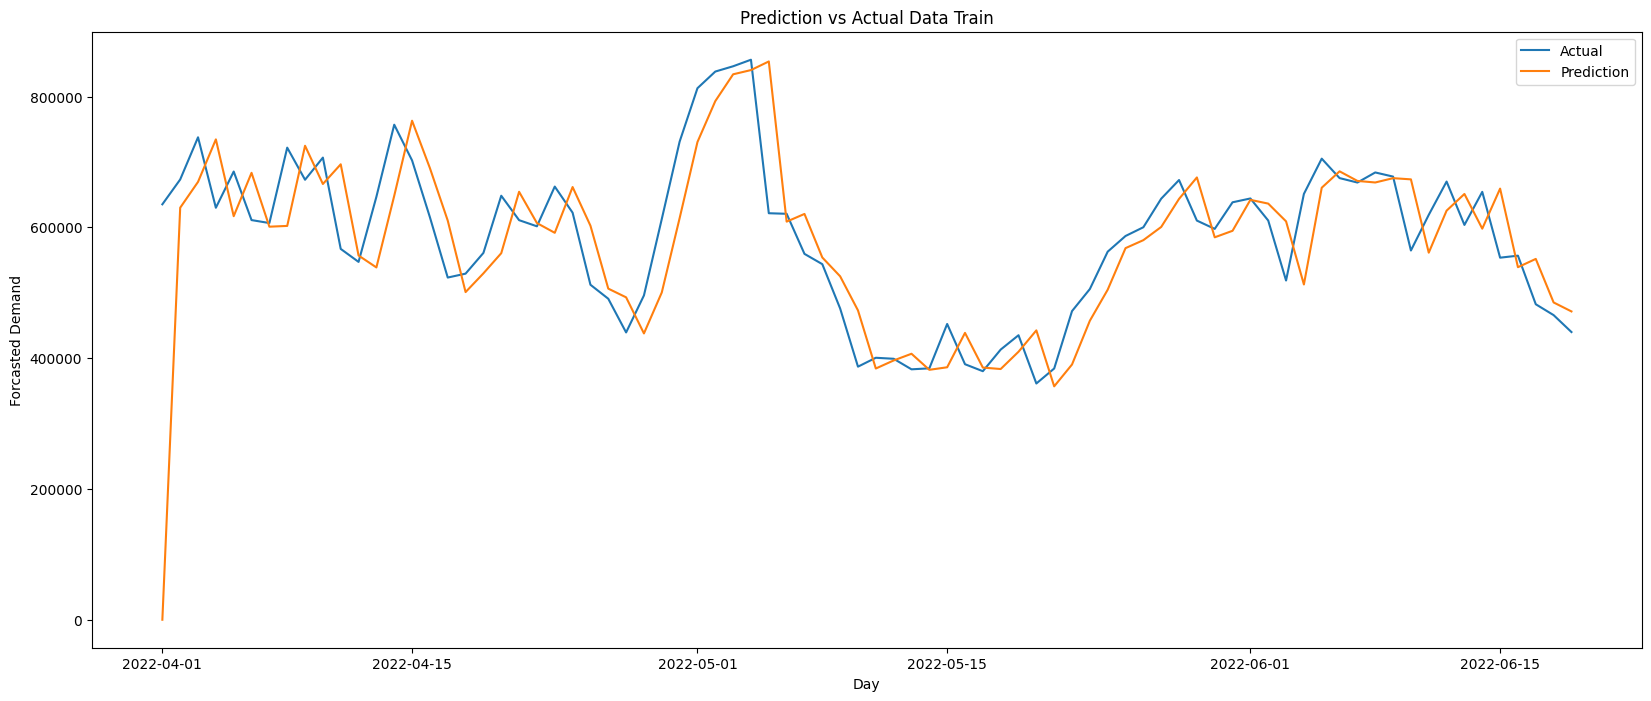

In [49]:
# Plot predict train
plt.figure(figsize=(20,8))
plt.plot(train['sales_sum'], label='Actual')
plt.plot(pred_train_sarimax, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Train')
plt.legend()
plt.show()

In [38]:
# Test prediction
pred_test_sarimax = result_sarimax.predict(start=(len(train['sales_sum'])), end=(len(train['sales_sum'])+len(test)-1), dynamic=False)
pred_test_sarimax = pred_test_sarimax.rename('predict')

# Concate with actual test-set
act_vs_pred_test_sarimax = pd.concat([test['sales_sum'], pred_test_sarimax], axis=1)
act_vs_pred_test_sarimax

,sales_sum,predict
2022-06-20,498641.0,418411.659673
2022-06-21,509995.0,421399.368031
2022-06-22,520920.0,423157.926552
2022-06-23,416522.0,418784.732884
2022-06-24,437710.0,412745.589989
2022-06-25,468786.0,420731.919152
2022-06-26,523264.0,427386.109419
2022-06-27,462018.0,408215.004772
2022-06-28,459203.0,411359.174990


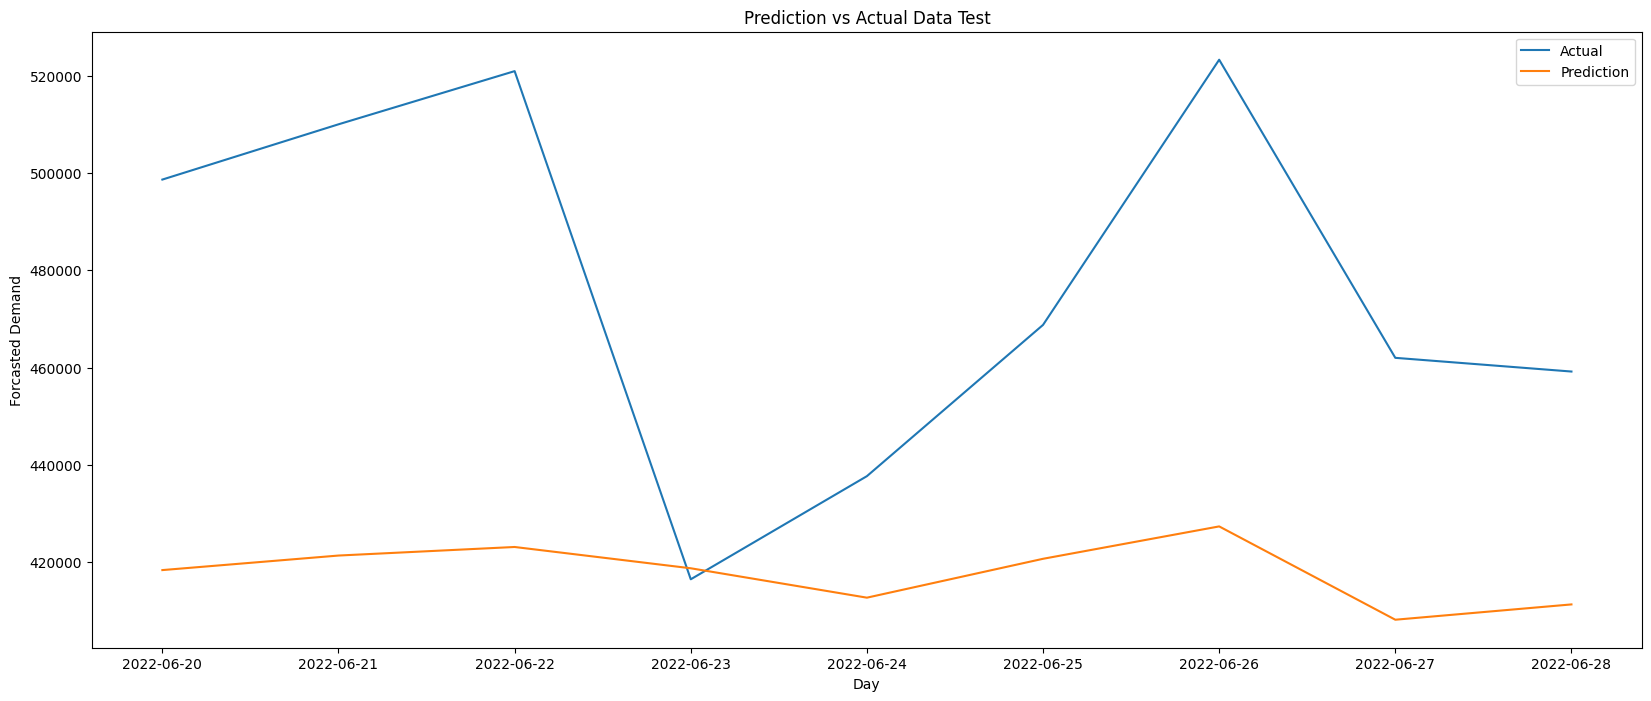

In [39]:
# plot predict test
plt.figure(figsize=(20,8))
plt.plot(test['sales_sum'], label='Actual')
plt.plot(pred_test_sarimax, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Test')
plt.legend()
plt.show()

### Evaluation
---

In [40]:
# Evaluation Train
mae_train_sarimax = mean_absolute_error(train['sales_sum'], pred_train_sarimax)

# Evaluation Test
mae_test_sarimax = mean_absolute_error(test['sales_sum'], pred_test_sarimax)

print(f"MAE Train : {mae_train_sarimax}")
print(f"MAE Test : {mae_test_sarimax}")

MAE Train : 59834.43725656207
MAE Test : 59932.553367307795


In [41]:
# Evaluation Train
mape_train_sarimax = mean_absolute_percentage_error(train['sales_sum'], pred_train_sarimax)

# Evaluation Test
mape_test_sarimax = mean_absolute_percentage_error(test['sales_sum'], pred_test_sarimax)

print(f"MAPE Train : {mape_train_sarimax}")
print(f"MAPE Test : {mape_test_sarimax}")

MAPE Train : 0.1025873285035888
MAPE Test : 0.12123689842447437


## Holt Winters
---

In [42]:
# Training
model_holt_win = ExponentialSmoothing(np.asarray(train['sales_sum']) ,seasonal_periods=7, trend='multiplicative', seasonal='multiplicative').fit()

# Print AIC Score
print("AIC Score: ", model_holt_win.aic)

AIC Score:  1806.506460719407


In [43]:
# Train prediction
pred_train_holt = pd.Series(model_holt_win.forecast(len(train['sales_sum'])), index= train.index)
pred_train_holt = pred_train_holt.rename('predict')

# Concate with actual train-set
act_vs_pred_train_holt = pd.concat([train['sales_sum'], pred_train_holt], axis=1)
act_vs_pred_train_holt

,sales_sum,predict
date,,
2022-04-01,635277.0,395699.925532
2022-04-02,673257.0,387514.603464
2022-04-03,737777.0,389431.831462
2022-04-04,630021.0,401402.486892
2022-04-05,685402.0,414935.988818
...,...,...
2022-06-15,553686.0,375871.104165
2022-06-16,556744.0,373555.383983
2022-06-17,482452.0,335273.777754


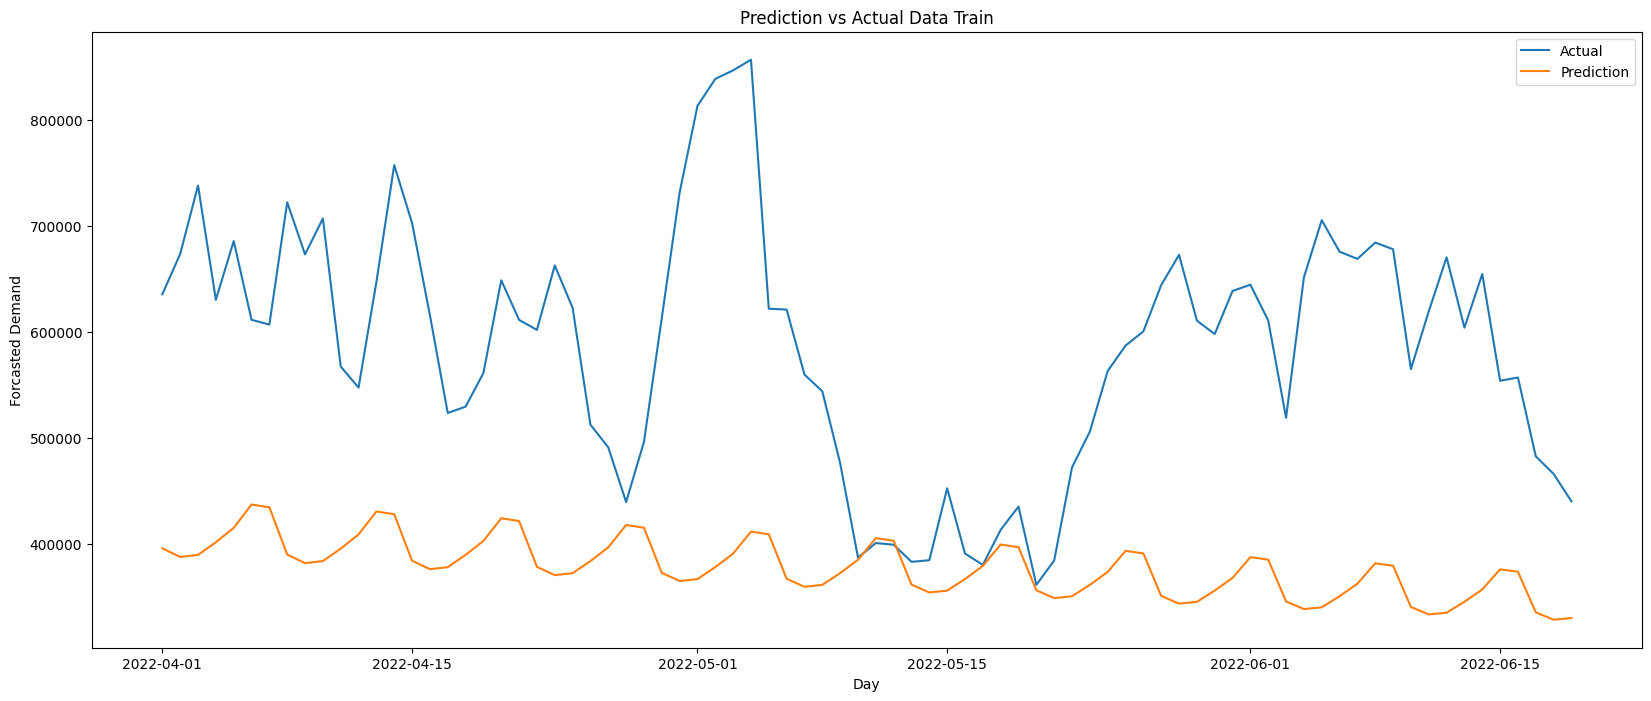

In [44]:
# Visualization data train
plt.figure(figsize=(20,8))
plt.plot(train['sales_sum'], label='Actual')
plt.plot(pred_train_holt, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Train')
plt.legend(loc='best')
plt.show()

In [45]:
# Test prediction
pred_test_holt = pd.Series(model_holt_win.forecast(len(test['sales_sum'])), index= test.index)
pred_test_holt = pred_test_holt.rename('predict')

# Concate with actual test-set
act_vs_pred_test_holt = pd.concat([test['sales_sum'], pred_test_holt], axis=1)
act_vs_pred_test_holt

,sales_sum,predict
date,,
2022-06-20,498641.0,395699.925532
2022-06-21,509995.0,387514.603464
2022-06-22,520920.0,389431.831462
2022-06-23,416522.0,401402.486892
2022-06-24,437710.0,414935.988818
2022-06-25,468786.0,436981.370176
2022-06-26,523264.0,434289.153171
2022-06-27,462018.0,389783.607103
2022-06-28,459203.0,381720.668105


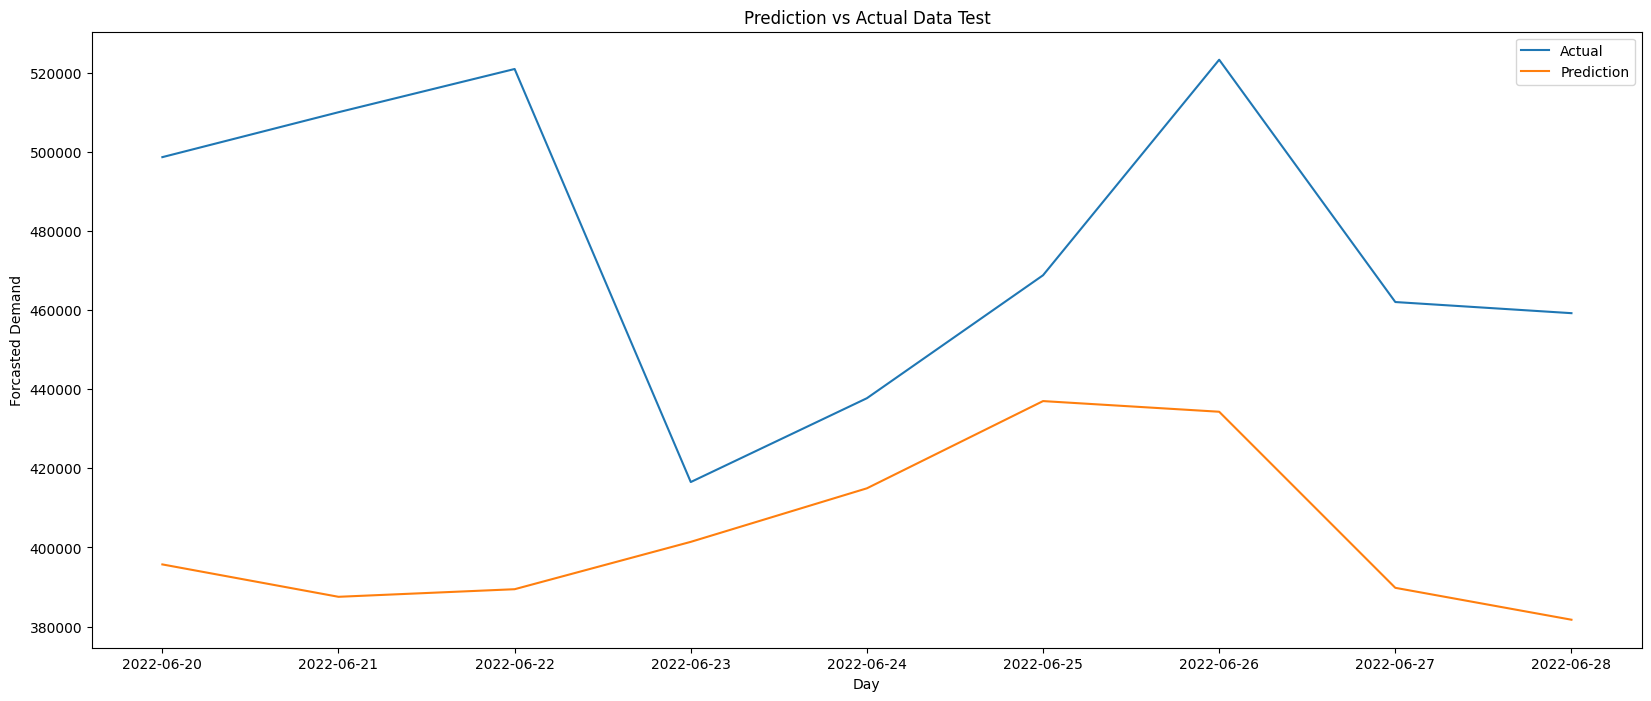

In [46]:
# Visualization data test
plt.figure(figsize=(20,8))
plt.plot(test['sales_sum'], label='Actual')
plt.plot(pred_test_holt, label='Prediction')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual Data Test')
plt.legend(loc='best')
plt.show()

### Evaluation
---

In [47]:
# Evaluation Train
mae_train_holt = mean_absolute_error(train['sales_sum'], pred_train_holt)

# Evaluation Test
mae_test_holt = mean_absolute_error(test['sales_sum'], pred_test_holt)

print(f"MAE Train : {mae_train_holt}")
print(f"MAE Test : {mae_test_holt}")

MAE Train : 208150.03954330063
MAE Test : 73922.15169759654


In [48]:
# Evaluation Train
mape_train_holt = mean_absolute_percentage_error(train['sales_sum'], pred_train_holt)

# Evaluation Test
mape_test_holt = mean_absolute_percentage_error(test['sales_sum'], pred_test_holt)

print(f"MAPE Train : {mape_train_holt}")
print(f"MAPE Test : {mape_test_holt}")

MAPE Train : 0.3284614472485475
MAPE Test : 0.15003425701075856
